The file species_info.csv contains data about different species and their conservation status

The file observations.csv holds recorded sightings of different species at several national parks for the past 7 days.

In [1]:
#importing the different Python modules 

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


In [2]:
#Loading the data 

species = pd.read_csv("species_info.csv")
obs = pd.read_csv("observations.csv") 

# Exploring the data 

In [3]:
#Explore the file species_info.csv

print(species.describe())
print("")
print(species.info())
print("")
print(species.head()) 

              category    scientific_name        common_names  \
count             5824               5824                5824   
unique               7               5541                5504   
top     Vascular Plant  Castor canadensis  Brachythecium Moss   
freq              4470                  3                   7   

       conservation_status  
count                  191  
unique                   4  
top     Species of Concern  
freq                   161  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB
None

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi g

In [4]:
#Explore the file observations.csv 

print(obs.describe())
print("")
print(obs.info())
print("")
print(obs.head())
print("")
print(f"Different Parks: {obs.park_name.unique()}")

       observations
count  23296.000000
mean     142.287904
std       69.890532
min        9.000000
25%       86.000000
50%      124.000000
75%      195.000000
max      321.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB
None

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Grea

# Handling missing values

In the file species_info.csv we have missing values in the column named conservation_status

In [5]:
#Missing values in the column conservation status 

print("% Missing data in conservation_status:")
print(np.round((1 - species.conservation_status.count() / species["category"].count())*100,2))

% Missing data in conservation_status:
96.72


In [6]:
#print the different categories and counts in the conservation_status column 

print(species.conservation_status.value_counts())

Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: conservation_status, dtype: int64


###### Comments: 

I have sampled several species with missing values in conservation status. If I could find this information online, the conservation status was always Least Concern (not being a focus of species conservation). For that reason, I'll replace the missing values with this category. It makes sense because this category is also missing from the list of different categories for the column. 

In [7]:
species['conservation_status'].fillna(value='Least Concern', inplace=True)


Check for duplicates in both files 

In [8]:
duplicates_species = species.duplicated()
duplicates_obs = obs.duplicated()
print(duplicates_species.value_counts())
print("")
print(duplicates_obs.value_counts())

False    5824
dtype: int64

False    23281
True        15
dtype: int64


We have 15 duplicates in the observations file. 

In [9]:
#Removing duplicates from the observations file. 

obs = obs.drop_duplicates()


In [10]:
#check which species categories we have and how many from each category 

print(species.category.value_counts())

Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: category, dtype: int64


The Vascular Plant category is by far the largest category of species. In total 4'470 species 

In [11]:
#add a variable that indicates whether a species is under protection 

species['is_protected'] = np.where(species.conservation_status != 'Least Concern', 'Yes', 'No')


# What is the distribution of conservation_status for animals?

In [12]:
#create a new df for animal species only  

animal_species = species[species['category'].str.contains('Plant') == False]

print(animal_species.category.value_counts())


Bird         521
Mammal       214
Fish         127
Amphibian     80
Reptile       79
Name: category, dtype: int64


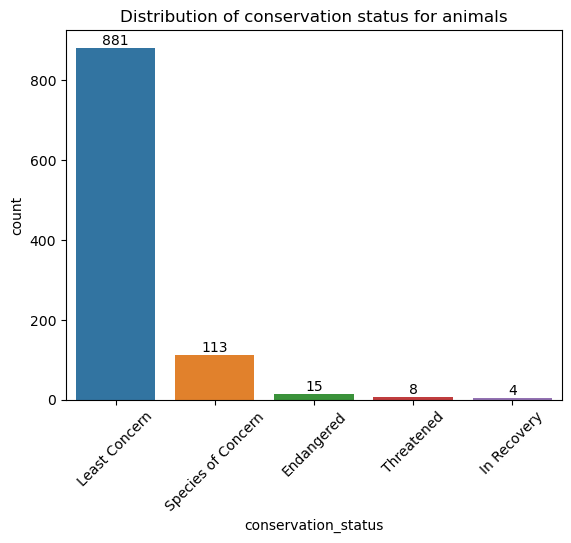

category,Amphibian,Bird,Fish,Mammal,Reptile
conservation_status,,,,,
Endangered,0.0125,0.007678,0.023622,0.032710,0.000000
In Recovery,0.0000,0.005758,0.000000,0.004673,0.000000
Least Concern,0.9125,0.848369,0.913386,0.822430,0.936709
Species of Concern,0.0500,0.138196,0.031496,0.130841,0.063291
Threatened,0.0250,0.000000,0.031496,0.009346,0.000000


<Figure size 640x480 with 0 Axes>

In [13]:
#show the distribution of conservation status for animals

ax = sns.countplot(data = animal_species, x='conservation_status')
ax.set_xticklabels(["Least Concern", "Species of Concern", "Endangered", "Threatened", "In Recovery"], rotation=45)
plt.title("Distribution of conservation status for animals")
ax.bar_label(ax.containers[0])
plt.show()
plt.clf() 

print("")
print("")

freq_table_1 = pd.crosstab(columns=animal_species['category'], index=animal_species['conservation_status'], normalize='columns')
freq_table_1

freq_table_2 = pd.crosstab(columns=animal_species['category'], index=animal_species['conservation_status'])
#freq_table_2

freq_table_1

- As we can see in the chart above, the dominant conservation status category for all animals is 'Least Concern', which means that the specific species is still plentiful in the wild. The second largest category is 'Species of Concern'. 

- Birds have a low proportion of endanghered species (less than 1%). In addition, the proportion of threatened species is 0%. Howevever, Birds have the highest proportion of Species of Concern (13.82%). If nothing is done about the species of concern, the proportions of threatened and endangered species might increase. 


# Are certain types of species more likely to be endangered?

In [14]:
#Create a freq table for all species and protection status 

freq_table_3 = pd.crosstab(index=species['category'], columns=species['is_protected'], normalize='index')
print(freq_table_3)

freq_table_4 = pd.crosstab(index=species['category'], columns=species['is_protected'])
freq_table_4

is_protected             No       Yes
category                             
Amphibian          0.912500  0.087500
Bird               0.848369  0.151631
Fish               0.913386  0.086614
Mammal             0.822430  0.177570
Nonvascular Plant  0.984985  0.015015
Reptile            0.936709  0.063291
Vascular Plant     0.989709  0.010291


is_protected,No,Yes
category,,
Amphibian,73,7
Bird,442,79
Fish,116,11
Mammal,176,38
Nonvascular Plant,328,5
Reptile,74,5
Vascular Plant,4424,46


- Based on the freq tables above, it can be seen that Birds and Mammals are more likely to be protected (% in protection status amount to 15.16% and 17.76% respectively).

- Plants have the lowest proportions of species that are protected.  

# Are the differences between categories of animal species and their protection status significant?

In [15]:
#perform the Chi-square test of independence of variables in a contingency table - Animals only 

freq_table_5 = pd.crosstab(index=animal_species['category'], columns=species['is_protected'])

print(freq_table_5)

print("")

stat, p, dof, expected = chi2_contingency(freq_table_5)


print(f"chi-square statistic: {stat}")
print(f"p-value: {p}")
print(f"degrees of freedom: {dof}")
print(f"expected values table:")
print(expected)


is_protected   No  Yes
category              
Amphibian      73    7
Bird          442   79
Fish          116   11
Mammal        176   38
Reptile        74    5

chi-square statistic: 11.928791576529253
p-value: 0.017888719961819517
degrees of freedom: 4
expected values table:
[[ 69.03036239  10.96963761]
 [449.56023506  71.43976494]
 [109.58570029  17.41429971]
 [184.65621939  29.34378061]
 [ 68.16748286  10.83251714]]


The aim of this chi-square test is to conclude whether the two variables (category and is_protected) are related to each other or not. 

H0: there is no relation between the variables
H1: there is a significant relationship between the two variables 
alpha = 5% 

The p-value from the test equals 1.79%. Hence, we reject the H0 at the 5% level. The conclusion is that the differences in protection status for the listed animal categories are significant.  

In [16]:
#We may want to add common names to the observations file. However, it's just easier to merge both files on scientific_name 

merged_df = pd.merge(species, obs, on='scientific_name')

# merged dataframe for animals only 

merged_animal_species = merged_df[merged_df['category'].str.contains('Plant') == False]


### Display the most spotted animals at each park 

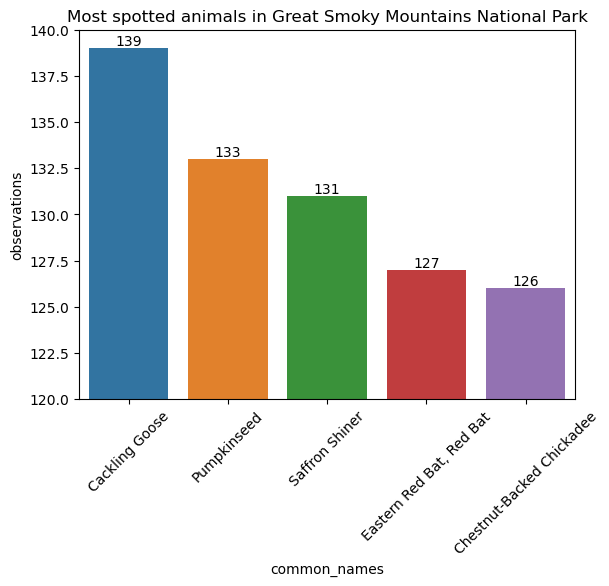

<Figure size 640x480 with 0 Axes>

In [17]:
#Great Smoky Mountains National Park 

df_smoky = merged_animal_species[merged_animal_species['park_name']=='Great Smoky Mountains National Park']

ax = sns.barplot(x="common_names",y='observations', data=df_smoky.nlargest(5, 'observations'))
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.ylim(120, 140)
plt.title("Most spotted animals in Great Smoky Mountains National Park")
plt.show()
plt.clf()  

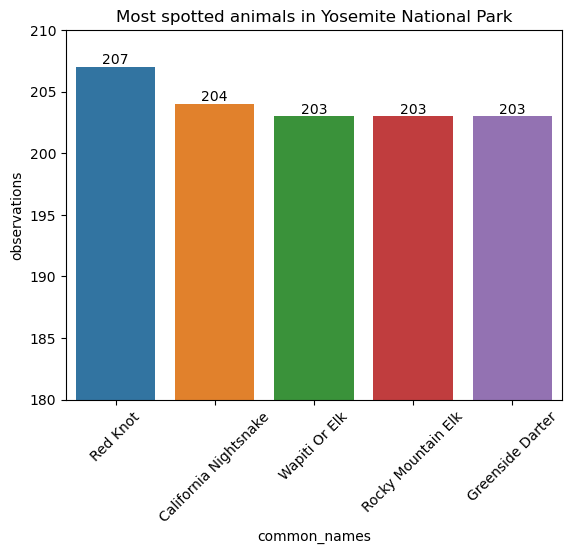

<Figure size 640x480 with 0 Axes>

In [18]:
#Yosemite National Park

df_yose = merged_animal_species[merged_animal_species['park_name']=='Yosemite National Park']

ax = sns.barplot(x="common_names",y='observations', data=df_yose.nlargest(5, 'observations'))
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.ylim(180, 210)
plt.title("Most spotted animals in Yosemite National Park")
plt.show()
plt.clf() 

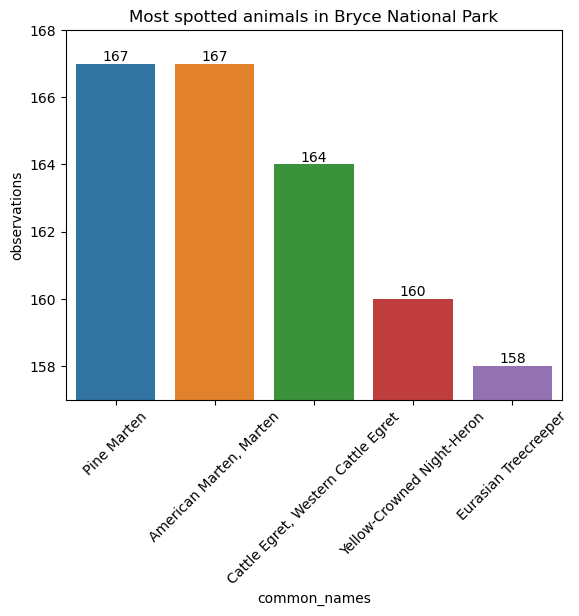

<Figure size 640x480 with 0 Axes>

In [19]:
#Bryce National Park

df_bryce = merged_animal_species[merged_animal_species['park_name']=='Bryce National Park']

ax = sns.barplot(x="common_names",y='observations', data=df_bryce.nlargest(5, 'observations'))
plt.xticks(rotation=45)
plt.ylim(157, 168)
ax.bar_label(ax.containers[0])
plt.title("Most spotted animals in Bryce National Park")
plt.show()
plt.clf() 

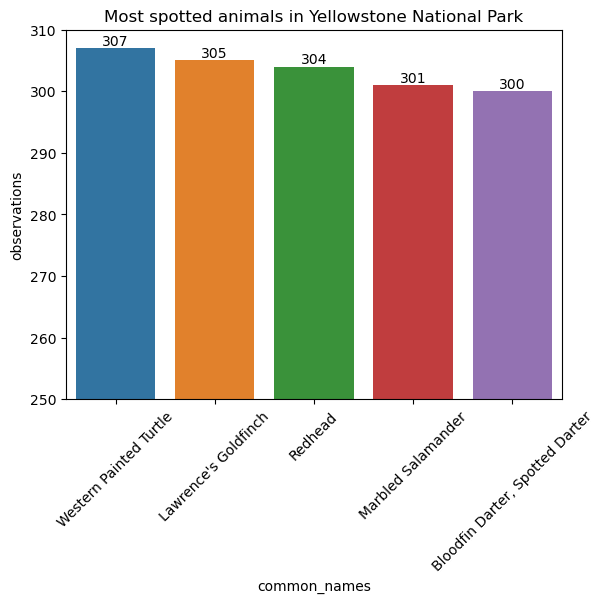

<Figure size 640x480 with 0 Axes>

In [20]:
#Yellowstone National Park

df_yellow = merged_animal_species[merged_animal_species['park_name']=='Yellowstone National Park']

ax = sns.barplot(x="common_names",y='observations', data=df_yellow.nlargest(5, 'observations'))
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.ylim(250, 310)
plt.title("Most spotted animals in Yellowstone National Park")
plt.show()
plt.clf()

# Which animal species were spotted the most at each park?

- In Yellowstone National Park, the most spotted animal was the western painted turtle. 

- In Yosemite National Park, the most spotted animal was a bird called Red Knot. 

- In Bryce National Park, the two most spotted animals were two different types of martens. 

- In Great Smoky Mountains National Park, the most spotted animal was the cackling goose. 


# Conclusions

- Throughout the process, I learned that Birds and Mammals are more likely to be under protection. Moreover, most animal species are not protected (881 non-protected vs 140 protected). 

- A key finding is that Birds have the highest proportion of Species of Concern in the dataset (13.82%). If nothing is done about this, the proportions of threatened and endangered species for Birds might increase. Obviosuly more resources need to be commited to stop the negative development. 

- The differences in protection status between categories of animal species are significant. Hence, some animal categories have significantly lower or higher proportions of protected species. 